# HW 4

Name: ChungHa Lee <br>
ID: 20232027

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

In [2]:
wage = pd.read_csv('./Dataset/Wage.csv')
wage.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
wage.drop(['Unnamed: 0'], axis = 1, inplace = True)
wage.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### Q5. Finding the best fit - Polynomial and Step function

(a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data. [6 pts]

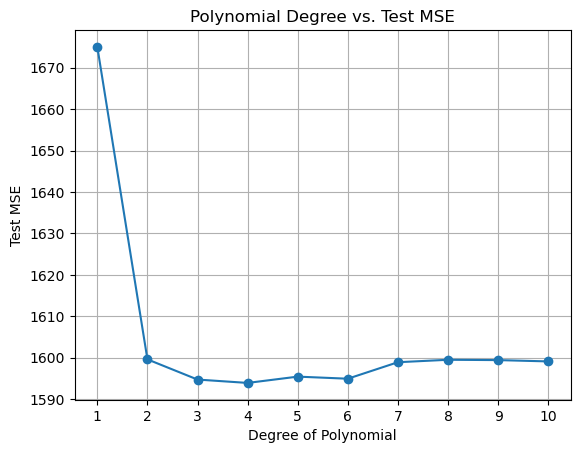

In [4]:
np.random.seed(1)

degree = 10

cv_errs = []

for i in range(1, degree + 1):
    polynomial_regression = make_pipeline(PolynomialFeatures(degree=i), LinearRegression())
    scores = cross_val_score(polynomial_regression, wage[['age']], wage['wage'], scoring='neg_mean_squared_error', cv=5)
    cv_errs.append(-np.mean(scores))

optimal_degree = np.argmin(cv_errs) + 1 

model = make_pipeline(PolynomialFeatures(degree=optimal_degree), LinearRegression())
model.fit(wage[['age']], wage['wage'])


degrees = list(range(1, degree + 1))
plt.plot(degrees, cv_errs, marker='o')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Test MSE')
plt.title('Polynomial Degree vs. Test MSE')
plt.xticks(degrees) 
plt.grid(True)
plt.show()

/Users/lifeofpy/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


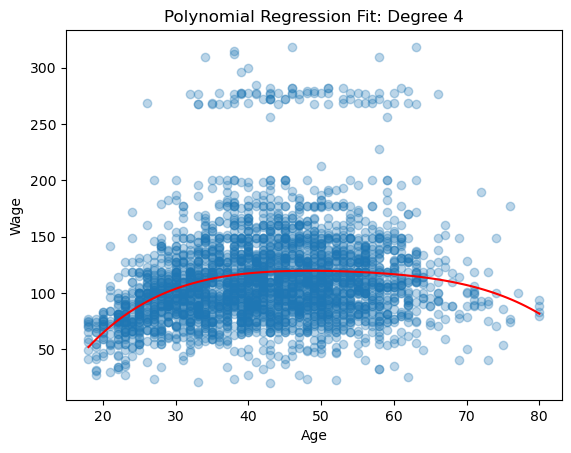

The optimal polynomial degree is 4


In [5]:
np.random.seed(1)

degree = 10

cv_errs = []

for i in range(1, degree + 1):
    polynomial_regression = make_pipeline(PolynomialFeatures(degree=i), LinearRegression())
    
    scores = cross_val_score(polynomial_regression, wage[['age']], wage['wage'], scoring='neg_mean_squared_error', cv=5)
    
    cv_errs.append(-np.mean(scores))


optimal_degree = np.argmin(cv_errs) + 1

model = make_pipeline(PolynomialFeatures(degree=optimal_degree), LinearRegression())
model.fit(wage[['age']], wage['wage'])

age_range = np.linspace(wage['age'].min(), wage['age'].max(), 100).reshape(-1, 1)
wage_pred = model.predict(age_range)

plt.scatter(wage['age'], wage['wage'], alpha=0.3)
plt.plot(age_range, wage_pred, color='red') 
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Polynomial Regression Fit: Degree ' + str(optimal_degree))
plt.show()

# Print the optimal degree
print(f"The optimal polynomial degree is {optimal_degree}")

(b) Fit a step function to predict wage using age, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

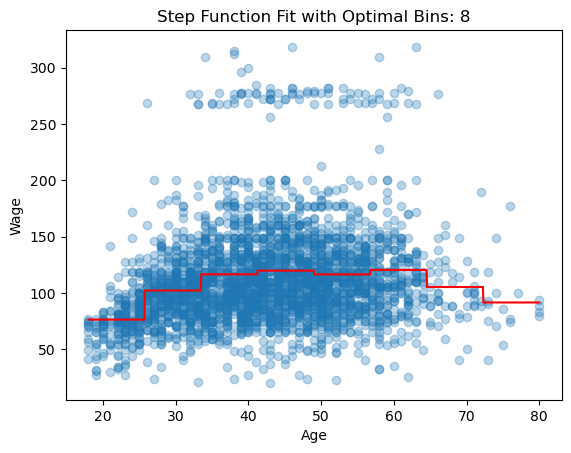

The optimal number of bins is 8


In [6]:
from sklearn.model_selection import KFold

np.random.seed(1)

max_bins = 10
cv_errs_bins = []

for bins in range(1, max_bins + 1):
    wage['age_bins'] = pd.cut(wage['age'], bins=bins, labels=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    mse_values = []
    
    for train_index, test_index in kf.split(wage):
        X_train, X_test = wage.iloc[train_index], wage.iloc[test_index]
        y_train, y_test = wage['wage'].iloc[train_index], wage['wage'].iloc[test_index]
        
        # Create dummy variables for the age bins and ensure alignment between train and test sets
        X_train_dummies = pd.get_dummies(X_train['age_bins']).reindex(columns=range(bins), fill_value=0)
        X_test_dummies = pd.get_dummies(X_test['age_bins']).reindex(columns=range(bins), fill_value=0)
        
        model = LinearRegression().fit(X_train_dummies, y_train)
        y_pred = model.predict(X_test_dummies)
        mse_values.append(mean_squared_error(y_test, y_pred))
    
    cv_errs_bins.append(np.mean(mse_values))

optimal_bins = np.argmin(cv_errs_bins) + 1

wage['age_bins'] = pd.cut(wage['age'], bins=optimal_bins, labels=False)
X_dummies_optimal = pd.get_dummies(wage['age_bins']).reindex(columns=range(optimal_bins), fill_value=0)
model_optimal_bins = LinearRegression().fit(X_dummies_optimal, wage['wage'])

plt.scatter(wage['age'], wage['wage'], alpha=0.3)

# Calculate the mean wage for each bin for plotting
bin_means = wage.groupby('age_bins')['wage'].mean().reindex(range(optimal_bins), fill_value=0)
age_range = np.linspace(wage['age'].min(), wage['age'].max(), 1000)
plt.plot(age_range, [bin_means.iloc[int(bin)] for bin in pd.cut(age_range, bins=optimal_bins, labels=False)], color='red')

plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Step Function Fit with Optimal Bins: ' + str(optimal_bins))
plt.show()

print(f"The optimal number of bins is {optimal_bins}")

### Q6. Finding the best fit - Regression Spline [7 pts]

In [7]:
boston = pd.read_csv('./Dataset/BostonHousing.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


(a) Use the bs() function from the ISLP.models to fit a regression spline to predict nox using dis. Report the resulting RSS by changing a range of degrees of freedom. Describe the results obtained.

In [8]:
import numpy as np
import pandas as pd
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(boston['dis'], boston['nox'], test_size=0.3, random_state=1)


degrees_of_freedom = range(3, 10)


rss_results = {}

for df in degrees_of_freedom:
    transformed_x_train = dmatrix("bs(train, df=df, include_intercept=False)", {"train": X_train}, return_type='dataframe')
    transformed_x_test = dmatrix("bs(test, df=df, include_intercept=False)", {"test": X_test}, return_type='dataframe')

    model = sm.GLM(y_train, transformed_x_train).fit()

    y_pred = model.predict(transformed_x_test)

    rss = mean_squared_error(y_test, y_pred) * len(y_test)
    rss_results[df] = rss

for df, rss in rss_results.items():
    print(f"Degree of freedom: {df}, RSS: {rss}")

Degree of freedom: 3, RSS: 0.5077364889926586
Degree of freedom: 4, RSS: 0.5129217636938456
Degree of freedom: 5, RSS: 0.4867715029446178
Degree of freedom: 6, RSS: 0.4827104381618496
Degree of freedom: 7, RSS: 0.48442961962382936
Degree of freedom: 8, RSS: 0.47086953520066105
Degree of freedom: 9, RSS: 0.49172497149163485


Based on these results, using 8 degrees of freedom seems to be the optimal choice for balancing model complexity and fit.

(b) Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data, and explain your results.

In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from patsy import dmatrix
import numpy as np

degrees_of_freedom_range = range(3, 10)
kf = KFold(n_splits=10, shuffle=True, random_state=1)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
cv_scores = {}

for df in degrees_of_freedom_range:
    transformed_x = dmatrix("bs(train, df=df, include_intercept=False)", {"train": boston['dis']}, return_type='dataframe')
    model = LinearRegression()
    scores = cross_val_score(model, transformed_x, boston['nox'], scoring=mse_scorer, cv=kf)
    cv_scores[df] = np.mean(scores)

optimal_df = min(cv_scores, key=cv_scores.get)
print(f"Optimal degree of freedom: {optimal_df}")
print(f"Cross-validation scores: {cv_scores}")


Optimal degree of freedom: 4
Cross-validation scores: {3: -0.003870023542757929, 4: -0.0038845250383175954, 5: -0.003709304169099549, 6: -0.003717702733026484, 7: -0.0037245386601015237, 8: -0.0037157868167940005, 9: -0.003758929188224247}


### Q7. Regression trees [13 pts]

(a) Split the data into a training and a test set, and fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [10]:
carseats = pd.read_csv('dataset/Carseats.csv')

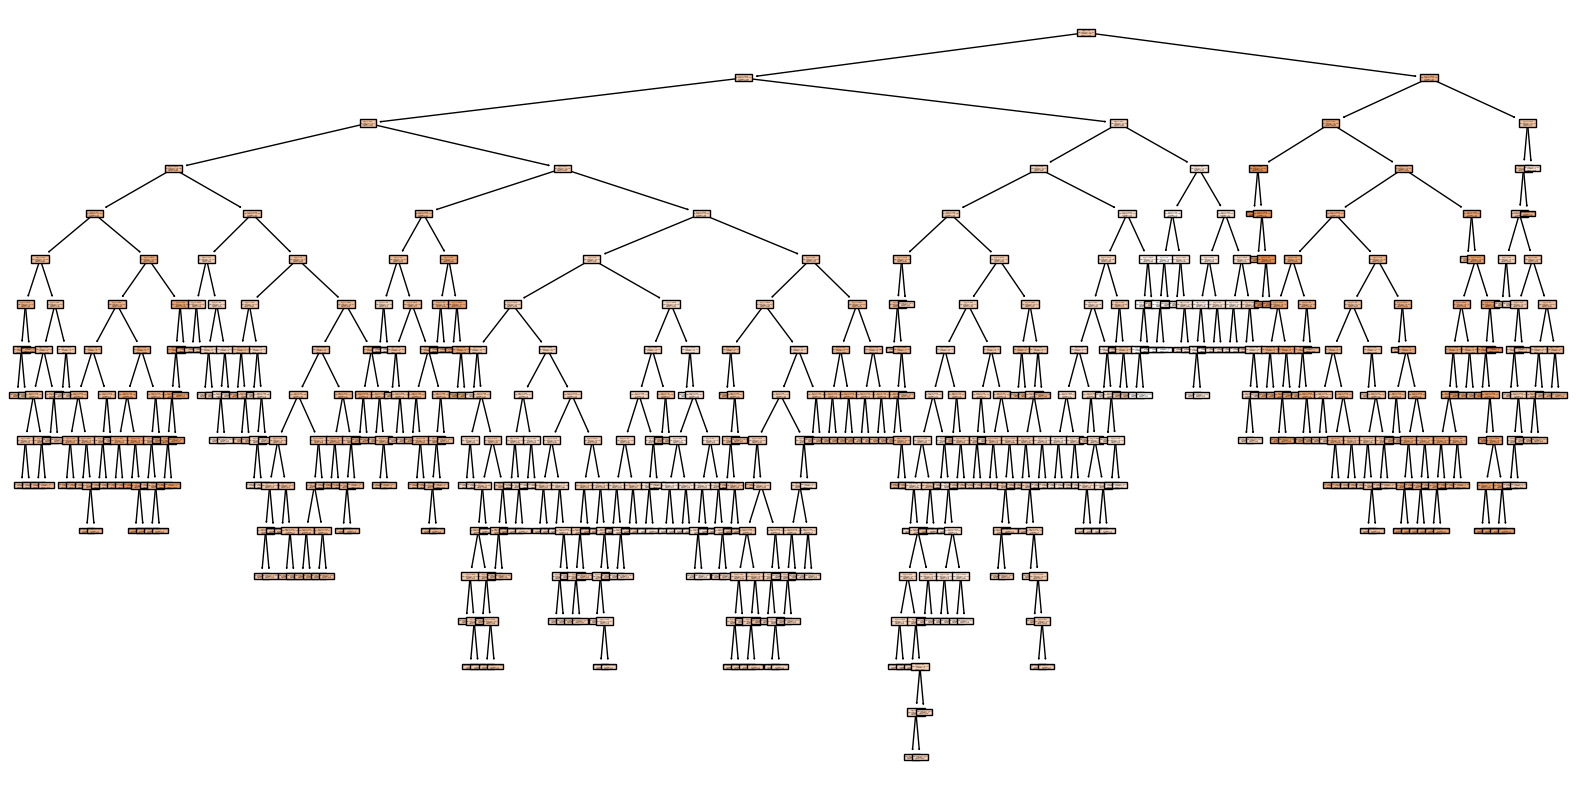

Test MSE: 5.421350000000001


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

X = pd.get_dummies(carseats.drop('Sales', axis=1))

y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(regressor, filled=True)
plt.show()

y_pred = regressor.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {test_mse}')

(b) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE? 

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

X = pd.get_dummies(carseats.drop('Sales', axis=1))
y = carseats['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=42)
param_grid = {'max_depth': np.arange(1, 20)}
regressor_cv = GridSearchCV(regressor, param_grid, cv=5)
regressor_cv.fit(X_train, y_train)

print(f"Best parameters: {regressor_cv.best_params_}")
print(f"Best cross-validation score: {-regressor_cv.best_score_}")

best_regressor = DecisionTreeRegressor(max_depth=regressor_cv.best_params_['max_depth'], random_state=42)
best_regressor.fit(X_train, y_train)

y_pred_unpruned = regressor.fit(X_train, y_train).predict(X_test)
y_pred_pruned = best_regressor.predict(X_test)

test_mse_unpruned = mean_squared_error(y_test, y_pred_unpruned)
test_mse_pruned = mean_squared_error(y_test, y_pred_pruned)

print(f"Test MSE (Unpruned): {test_mse_unpruned}")
print(f"Test MSE (Pruned): {test_mse_pruned}")

improvement = test_mse_unpruned - test_mse_pruned
print(f"Improvement in Test MSE after pruning: {improvement}")

Best parameters: {'max_depth': 7}
Best cross-validation score: -0.31905624505499697
Test MSE (Unpruned): 5.421350000000001
Test MSE (Pruned): 5.6261054218020705
Improvement in Test MSE after pruning: -0.2047554218020693


The answer is **NO**.

(c) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature importance values to determine which variables are most important.

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

X = pd.get_dummies(carseats.drop('Sales', axis=1))
y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bagging_regressor = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)

bagging_regressor.fit(X_train, y_train)

y_pred = bagging_regressor.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse}")

feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_regressor.estimators_
], axis=0)

features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

print(features.sort_values(by='Importance', ascending=False))

/Users/lifeofpy/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Test MSE: 3.0323344804999985
             Feature  Importance
4              Price    0.303718
8     ShelveLoc_Good    0.169989
5                Age    0.120814
0          CompPrice    0.090599
2        Advertising    0.086154
7      ShelveLoc_Bad    0.066423
1             Income    0.050794
3         Population    0.038964
9   ShelveLoc_Medium    0.030811
6          Education    0.029292
10          Urban_No    0.004104
11         Urban_Yes    0.003384
12             US_No    0.002694
13            US_Yes    0.002261


The most important feature is the **'price'**.

(d) Use random forests to analyze this data. What test MSE do you obtain? Use the feature importance function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained. 

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = pd.get_dummies(carseats.drop('Sales', axis=1))
y = carseats['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_regressor.fit(X_train, y_train)
y_pred = random_forest_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse}")

feature_importances = random_forest_regressor.feature_importances_
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
print(features.sort_values(by='Importance', ascending=False))

error_rates = []
for m in range(1, X_train.shape[1] + 1):
    rf = RandomForestRegressor(n_estimators=100, max_features=m, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    error_rates.append((m, mse))

for m, mse in error_rates:
    print(f"m: {m}, Test MSE: {mse}")

Test MSE: 3.068886088875
             Feature  Importance
4              Price    0.303445
8     ShelveLoc_Good    0.169176
5                Age    0.121328
0          CompPrice    0.090437
2        Advertising    0.085365
7      ShelveLoc_Bad    0.066745
1             Income    0.051375
3         Population    0.038082
9   ShelveLoc_Medium    0.031215
6          Education    0.029796
11         Urban_Yes    0.004490
10          Urban_No    0.003395
12             US_No    0.003119
13            US_Yes    0.002032
m: 1, Test MSE: 5.203345804625
m: 2, Test MSE: 4.316106159249999
m: 3, Test MSE: 3.972263892624998
m: 4, Test MSE: 3.563161685374996
m: 5, Test MSE: 3.3566143739999985
m: 6, Test MSE: 3.264819798875
m: 7, Test MSE: 3.277892378499999
m: 8, Test MSE: 3.2547201535
m: 9, Test MSE: 3.1861440483749988
m: 10, Test MSE: 2.9893126311250007
m: 11, Test MSE: 3.038109651249999
m: 12, Test MSE: 3.1819654303749987
m: 13, Test MSE: 3.1246502852499978
m: 14, Test MSE: 3.068886088875


When m is small, each split in each tree in the forest is considering a very small subset of the features. 

As m approaches the total number of features, the trees become less diverse and more similar to each other, which can lead to overfitting.

### Q8. Boosted trees and its competitors [10 pts]

(a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries. Next, create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations. Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce two plots: one with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis, another with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis. [5 pts]

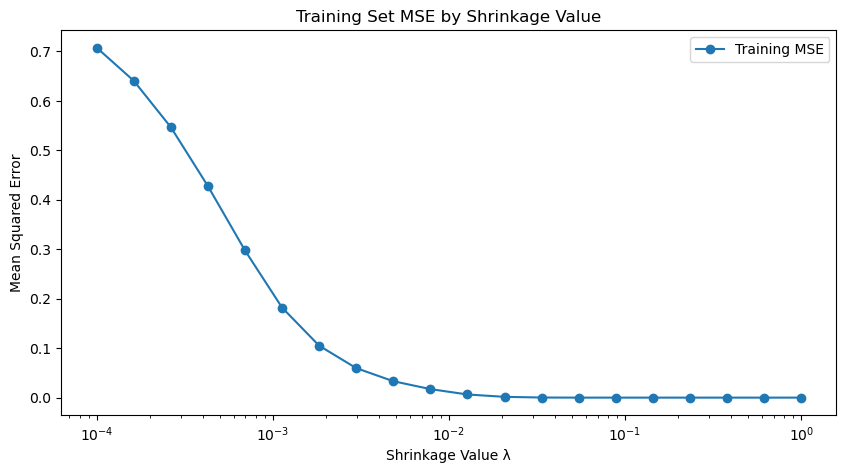

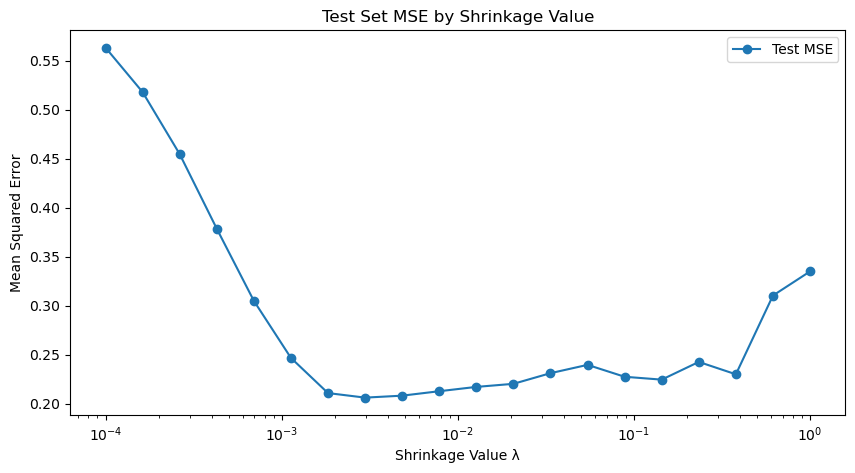

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

hitters = pd.read_csv('dataset/Hitters.csv')
hitters.drop(['Unnamed: 0'], axis = 1, inplace = True)
hitters = hitters.dropna(subset=['Salary'])
hitters['Salary'] = np.log(hitters['Salary'])

train = hitters[:200]
test = hitters[200:]

X_train = pd.get_dummies(train.drop('Salary', axis=1))
y_train = train['Salary']
X_test = pd.get_dummies(test.drop('Salary', axis=1))
y_test = test['Salary']

shrinkage_values = np.logspace(-4, 0, 20)
train_mse = []
test_mse = []

for shrinkage in shrinkage_values:
    gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=shrinkage, random_state=42)
    gbr.fit(X_train, y_train)
    
    y_train_pred = gbr.predict(X_train)
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    
    y_test_pred = gbr.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(10, 5))
plt.plot(shrinkage_values, train_mse, label='Training MSE', marker='o')
plt.xscale('log')
plt.xlabel('Shrinkage Value λ')
plt.ylabel('Mean Squared Error')
plt.title('Training Set MSE by Shrinkage Value')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(shrinkage_values, test_mse, label='Test MSE', marker='o')
plt.xscale('log')
plt.xlabel('Shrinkage Value λ')
plt.ylabel('Mean Squared Error')
plt.title('Test Set MSE by Shrinkage Value')
plt.legend()
plt.show()

(b) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapter 3 and 6 of the book.

In [16]:
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
test_mse_linear = mean_squared_error(y_test, y_pred_linear)

ridge_model = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-6, 6, 13)))
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
test_mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"Test MSE (Linear Regression): {test_mse_linear}")
print(f"Test MSE (Ridge Regression): {test_mse_ridge}")
print(f"Test MSE (Boosting): {test_mse}")

Test MSE (Linear Regression): 0.4917959375454912
Test MSE (Ridge Regression): 0.4567021750482599
Test MSE (Boosting): [0.5633448239228975, 0.5179727496261008, 0.45469040425725676, 0.3785566709781856, 0.30496116695202313, 0.24666187508012924, 0.2107407868348783, 0.20610533469183226, 0.20810399319960635, 0.21264077394636297, 0.21704388508982178, 0.22018675825056225, 0.2310603770264807, 0.23954548561441052, 0.22739155583315732, 0.2244628347984469, 0.24254331118797648, 0.2299080337279404, 0.3103054157750935, 0.33491540029383127]


(c) Which variables appear to be the most important predictors in the boosted model?

In a boosted model, the most important predictors are the variables that contribute the most to predicting the outcome. 
These key variables are given the highest importance scores by the model, indicating they are the top factors in making accurate predictions.